<h1 align="center">MAPD - mod. B - PoD<br> University of Padua <br> 2022/2023 <br> Batch analysis of cosmic rays using Drift Tubes detectors</h1>

<p align="center">
  <img src="https://user-images.githubusercontent.com/62724611/166108149-7629a341-bbca-4a3e-8195-67f469a0cc08.png" height="150"/>
   
  <img src="https://user-images.githubusercontent.com/62724611/166108076-98afe0b7-802c-4970-a2d5-bbb997da759c.png" height="150"/>
</p>

<h3 align="center"><b>Group 06:</b> A. Saccomani, E. Sarte, R. Tancredi, G. Zago<br></h3>

## Introduction

The goal of this project is to analyze real data collected in a particle physics detector to reconstruct the trajectory of muons from cosmic rays. Data are collected using Drift Tubes detectors based on ionization: charged particles ionize the gas mixture inside the detectors, producing electron-ion pairs. The electron velocity drift is fixed at $v_{drift} = 53.8 \:\mu m/ns$ thanks to specifically shaped electric fields. Signals are collected on the anodic wire, then amplified, digitalized, discriminated, and
sent through a DAQ system where a set of FPGAs perform the Time-to-Digital Conversion (TDC): to each electron cloud reaching the wire a digital signal is associated corresponding to the time of collection.
Each digitized signal is commonly referred to as an **hit**. 


## Objective

The goal of the project is to **preprocess** the dataset in order then to use the proper data for the analysis. After that it's possible to estimate the muon trajectories inside the telescope reconstructing two types of trajectories: **Local** and **Global**. After that a final result is obtained by plotting the angle of the global track and the local track
measured from **Chamber 2**, as this provides an estimate of the detector
angular resolution.



# Cluster setup
To perform the preprocessing and the whole analysis, we have set-up a cluster with 3 virtual machines (VMs) located in **CloudVeneto**. 

The cluster has been deployed by running the **Dask scheduler process** and the **Dask worker process** on the first VM, while on the other two VMs, only the **Dask worker process** has been run. This processes have been launched by *command line*, after having installed the latest Dask distribution available on each VM, with root permission. 

```bash
$ dask scheduler
Scheduler at:   tcp://192.0.0.100:8786

# for each worker:
$ dask worker tcp://192.0.0.100:8786
Start worker at:  tcp://192.0.0.1:12345
Registered to:    tcp://192.0.0.100:8786

```

In this way, we have one VM acting both as a scheduler and a worker, while the other two acting as workers only. We have 12 total threads, 4 for each worker. 

In order to send tasks to the scheduler and work in the Dask environment, we have launched a *Jupyter notebook server* on the first VM and then connected to its kernel through a ssh link. 

In [1]:
from dask.distributed import Client
client = Client("localhost:8786")

In [2]:
client

<Client: 'tcp://10.67.22.157:8786' processes=3 threads=12, memory=23.28 GiB>

## Data structure

The raw dataset is provided on a cloud storage s3 bucket hosted on CloudVeneto. The name of the Bucket is $\texttt{mapd-minidt-batch}$.

<!-- Link to visualize the list all contained files: https://cloud-areapd.pd.infn.it:
5210/swift/v1/AUTH_d2e941ce4b324467b6b3d467a923a9bc/mapd-minidt-batch/

Instructions: http://userguide.cloudveneto.it/en/latest/ManagingStorage.html#
object-storage-experimental -->

In order to access the bucket and the retrieve all the files stored inside it, the credentials needed to access the files were provided by the CloudVeneto:

```bash
cat credentials.json
{
    "access_key":"aaaabbbbccccddddeeeeffff", 
    "secret_key":"gggghhhhiiiijjjjkkkkllll"
}
```

The dataset is composed of multiple binary files encoding the stream of hits collected:
* Every hit is encoded as a 64bit word
* Each word has the exact same structure

The 64b data-format complies to the following standard:
* 0-4 (5 bit) -> **TDC**
* 5-16 (12 bit) -> **BX**
* 17-48 (32 bit) -> **ORBIT**
* 49-57 (9 bit) -> **CHAN**
* 58-60 (3 bit) -> **FPGA**
* 61-63 (3 bit) -> **HEAD**

Each event is identified by a **unique ORBIT value**.

## Data unpacking

After having read the unstructured data, we unpacked these raw objects into a structured dataframe containing the 6 columns of interest (**TDC**, **BX**, **ORBIT**, **CHAN**, **FPGA**, **HEAD**). 

To do this in **Dask** we used the function `read_bytes` from `dask.bytes` in order to read and decode binary files. We read the files into a fixed number of blocks (partitions) that we initially set to 81, equal to the number of files (each file is about 10 Mb). After that with the function **process**, we transformed the binary data into decimal numbers in the way described before using the numpy function `frombuffer`. 

Finally, we created a dataframe of the blocks using the `from_delayed` method from `dask.dataframe`. 

In [3]:
import json
import dask.bag as db
import dask.array as da
import dask.dataframe as dframe
import dask.bytes as dbytes
import dask.delayed
import numpy as np
import pandas as pd
import itertools
import time

In [4]:
start = time.time()

In [5]:
with open("credentials.json") as f:
    cred = json.load(f)

### Load data

In [6]:
# Configure S3 endpoint URL and credentials
bucket_name = 'mapd-minidt-batch'
credentials = {"key":cred['access_key'], 
                "secret":cred['secret_key'], 
                "endpoint_url":'https://cloud-areapd.pd.infn.it:5210'}

urlpaths=[f's3://{bucket_name}/data_{i:06}.dat' for i in range(0, 81)]

sample, blocks = dbytes.read_bytes([url for url in urlpaths], **credentials)

In [7]:
@dask.delayed
def process(bytes):
    data = np.frombuffer(bytes, dtype=np.ulonglong, count=len(bytes) // 8)
    tdcs = data & 0b11111
    bxs = (data >> 5) & 0b1111_11111111
    orbits = (data >> 17) & 0b11111111_11111111_11111111_11111111
    chans = (data >> 49) & 0b1_11111111
    fpgas = (data >> 58) & 0b111
    heads = data >> 61
    
    mat = np.column_stack((tdcs, bxs, orbits, chans, fpgas, heads))
    mat = mat[(mat[:, 5] == 2)]

    return pd.DataFrame(data=mat, columns=["TDC", "BX", "ORBIT", "CHANNEL", "FPGA", "HEAD"], index=mat[:, 2])

data = dframe.from_delayed([process(p[0]) for p in blocks])

## Dataset cleansing
After loading the dataset, we needed to sanitize it in order to continue with the analysis of the trajectories. We needed to select the data that pertain to the TDC hits. The **HEAD** is an header informing which word is associated to the TDC hits (marked with **HEAD** == 2). The other value of **HEAD** (0,1,3,4,5) have been discarded. Then, we mapped each row to the correspondent chamber following these mapping:
* **Chamber0** -> (**FPGA** = 0) and (**CHANNEL** in [0-63])
* **Chamber1** -> (**FPGA** = 0) and (**CHANNEL** in [64-127])
* **Chamber2** -> (**FPGA** = 1) and (**CHANNEL** in [0-63])
* **Chamber3** -> (**FPGA** = 1) and (**CHANNEL** in [64-127])

Chambers contain 64 cells arranged in 4 layers of 16 cells each. A single cell is made up of $42\cdot13$ $mm^2$ (width X height) and it follows a specific recurrent pattern enumeration, given the **CHANNEL** value.
Three chambers (0,2,3) are in the same orientation and the fourth (1) is rotated 90 degrees, in order to measure in the orthogonal view. To measure the 2D trajectory we will use only chamber (0,2,3) so we discard all entries with (**Chamber** == 1).
With the functions **manipulate_data** and **get_layers** we added the column of the dataset defining the position of the hit in the layout of the detector. We then assigned to each hit the corresponding chamber, layer and cell.
Another computation performed was to group the rows by **ORBIT** and maintain only the groups that have one row with (**FPGA** == 1 and **CHANNEL** == 128). This represents the passage time of the muon $t_0$, provided by the external scintillator signal. 
We also kept only the first hit in the same cell, and eliminated some ancillary data in the dataset (like **CHANNEL** == 138).

### Improving dataset readibility
Now that we have the filtered rows, our goal is to apply some additional oparation so to obtain useful quantities to then analyze the trajectories. First we assigned the vertical position of the chamber and corrected the time offset of $t_0$, that is near $95 ns$ but has little differences between different chambers. This is because the time information from the scintillator is roughly $95 ns$ ahead with respect to the actual time of passage of a muon.

### Time information:
We need to manage the three time counters provided by each signal to obtain the actual time of the passage in $ns$. The three counters are the following:
* 1 **ORBIT** = 3564 **BX**
* 1 **BX** = 25 ns
* 1 **TDC** = 1/30 **BX**

An absolute time can be associated to each hit by converting the counters as follows:
$t_{hit}(ns) = 25 \cdot (\textbf{ORBIT} \cdot 3564 + \textbf{BX} + \textbf{TDC}/30)$

### Space information:
Now given the time information, we computed the position inside the cell where the hit has happened. Thanks to the constant $v_{drift}$ we can write:
\begin{equation*}
    x_{hit}=(t_{hit}-t_0)\cdot v_{drift}
\end{equation*}

This value leaves a left-right ambiguity. We know the distance between the trajectory of the muon and the anode (center of the cell) but we do not know if the muon has passed in the right-half or in the left-half of the cell. To solve this ambiguity, we need more analysis on the possible trajectories of the muon. We also calculated the vertical distance using the parameter given for each chamber and the height of the layers.

### Further cleansing of the dataset
To get useful data to continue with the analysis we need to apply other constraints to each event: to each unique value of **ORBIT**, first we discarded every event in which there were unphysical values of the position (for example points that have distance from the anod bigger than half of the length of the cell, or time $t_{hit}$ below $t_0$). Then, we limited the dataframe to the events that have at least two hits per chambers and a maximum of 12 hits per chamber, with a maximum of 3 hits per layer. 

Now data is ready for the next computation.

In [8]:
def get_layers(cells):
    # Here we assign the correct LAYER only to the cell belonging to layer 0 and 3
    # because the modulo operator is good only for the layer 0 and 3, not the 1 and 2
    # because the 4*k cell is in the first row, the 4*k+3 cell is in the fourth row, but
    # the 4*k+1 is in the third and the 4*k+2 in the second, so these last two are flipped
    layers = cells % 4
    # Here we swap layer 1 with layer 2 (the incorrect ones)
    return np.where((layers == 1) | (layers == 2), layers % 2 + 1, layers)

def filter_chambers(x):
    # Minimum number of differnt layers hit per chamber
    MIN_UNIQUE_LAYERS_HIT = 2
    # Maximum number of hits per chamber
    MAX_HITS_PER_CHAMBER = 8
    # Minimum number of hits per chamber
    # In this case, equal to the layers hits
    MIN_HITS_PER_CHAMBER = MIN_UNIQUE_LAYERS_HIT
    # Maximum number of hits per layer (of a single chamber)
    MAX_HITS_PER_LAYER = 3
    # Minimum number of 'good chambers', in order to consider the whole event
    # See below for the definition of 'good chamber' 
    MIN_GOOD_CHAMBERS = 2

    # x is dataframe only containing the hits from the same orbit
    good_ch = 0
    # We now subset that dataframe grouping by chamber
    for ch, df_ch in x.groupby("CHAMBER"):
        
        # If the numbers of hits in this chamber is greater than the maximum allowed we discard
        # the whole event (if we return False, pandas know to not consider the orbit in input to
        # this function)
        
        if len(df_ch) > MAX_HITS_PER_CHAMBER:
            return False

        # If in this chamber there is the minimum number of hits
        if len(df_ch) >= MIN_HITS_PER_CHAMBER:
            # and if there is the minimum number of layer hit
            if len(df_ch.LAYER.value_counts()) >= MIN_UNIQUE_LAYERS_HIT:
                # and the number if hits in the same layer is allowed,
                # then this chamber is a good chamber
                if np.all(df_ch.LAYER.value_counts() <= MAX_HITS_PER_LAYER):
                    # and we increment the good chamber count
                    good_ch += 1

    # If this event (same orbit) has at least the minimum number of 'good chamber', then we keep it,
    # otherwise we return false and filter it out
    return good_ch >= MIN_GOOD_CHAMBERS

In [9]:
# The aim of this function is to take the original dataframe and to create a new one with only the 
# events of interest, adding useful columns
def manipulate_dataframe(df):    
    TIME_OFFSETS = np.array(
        [95.0 - 1.1,  # Ch 0
        95.0 + 6.4,  # Ch 1
        95.0 + 0.5,  # Ch 2
        95.0 - 2.6]  # Ch 3
    )

    SPACE_OFFSETS = np.array([219.8, 977.3, 1035.6, 1819.8])
    CELL_WIDTH = 42
    CELL_HEIGHT = 13

    # we eliminate all hits on chamber 1
    df = df[~((df.FPGA == 0) & (df.CHANNEL >= 64) & (df.CHANNEL <= 127))]

    # we keep only the first hit in the same cell (to do that we sort by 'time' and keep the first)
    df = df.sort_values(by=["ORBIT", "BX", "TDC"])
    df = df.drop_duplicates(["ORBIT", "CHANNEL", "FPGA"])  # by default it keeps the first

    # we create the column for the time (we don't include orbit because we don't want to compare
    # hits in different event, but only hits from the same events so adding the orbit it's just
    # like adding an offset equal for every hit
    df["TIME"] = 25 * df.BX + df.TDC * 25 / 30

    # We keep only the orbits with a t0 (todo: check if there is only one t0)
    mask_t0 = (df.FPGA == 1) & (df.CHANNEL == 128)
    orbits_with_t0 = df.loc[mask_t0, ('ORBIT', "TIME")]  # list of orbits which contain a t0 row
    df = df[df.ORBIT.isin(orbits_with_t0.ORBIT.unique())]  # we keep only the orbit in that list

    # we rename the TIME columns for the t0s to T0 and then merge with the original df on ORBIT
    # in this way we obtain a new column called T0 for every hit which contains the t0 of the event
    # associated with that orbit
    orbits_with_t0.rename(columns={'TIME': 'T0'}, inplace=True)
    df = pd.merge(df, orbits_with_t0, on='ORBIT', how='inner')

    # We remove the column with t0 and the infamous channel 138 (we don't know what is that)
    df = df[(df.CHANNEL != 128) & (df.CHANNEL != 138)]

    # Here we create some column
    df["CHAMBER"] = np.round(df.FPGA * 2 + df.CHANNEL // 64)
    # Cell is a number from 0-63 for every chamber (like shown in the pdf)
    df["CELL"] = (df.CHANNEL - (df.CHAMBER % 2) * 64)
    df["LAYER"] = get_layers(df.CELL)

    # Here we assign to every hit the position of the central cable of that cell (basically the center of the cell)
    df["CELL_X"] = (df.CELL // 4) * CELL_WIDTH + CELL_WIDTH * 0.5 + CELL_WIDTH * 0.5 * (df.LAYER % 2)
    df["CELL_Y"] = SPACE_OFFSETS[df.CHAMBER] + (4 - df.LAYER) * CELL_HEIGHT - CELL_HEIGHT * 0.5

    # time correction (there is a different t0 for each chamber)
    df["T0"] = df.T0 - TIME_OFFSETS[df.CHAMBER]
    # We calculate the distance using the drift time, and then convert it from um to mm
    df["REL_TIME"] = df.TIME - df.T0
    df["DISTANCE"] = df.REL_TIME * 53.8 / 1000

    # We keep only the distances in the range [0, 21] because are the only distances possible (half cell width)
    df = df[(df.DISTANCE >= 0) & (df.DISTANCE <= 21)]

    # In this function we check if there are at least 'MIN_GOOD_CHAMBERS' chambers
    # What is a good chamber? A good chamber is when
    # the chamber has at least 'MIN_HITS_PER_CHAMBER' hits in total
    # the chamber has at least 'MIN_UNIQUE_LAYERS_HIT' layers hit
    
    # But if we find a chamber with more than 'MAX_HITS_PER_CHAMBER' hits, then we discard the whole event
    # We groupby orbit and then each subgroup is sent to the function to check if it's good (return True)
    # or we have to filter it out (return False)
    df = df.groupby(["ORBIT"]).filter(filter_chambers)

    # We finally sort the hits
    df = df.sort_values(by=["ORBIT", "CHAMBER", "LAYER", "CELL"])
    
    # We add 2 more columns: we will need them in further computations
    # This step is highly suggested, to avoid futher problems with
    # dask `meta` and the columns present in the dataframe
    df['HIT_X'] = np.nan
    df['HIT_X2'] = np.nan
    
    return df

Now that we have all the files loaded, we change the number of partitions for the next analysis. 

In [10]:
data = data.repartition(npartitions=150)

In [11]:
print(f"The number of partitions is {data.npartitions}")

The number of partitions is 150


To apply this function to all the dask dataframes we use the command **map_parititions**, so that the function is applied to each partition. Each of these contains a **pandas dataframe** given in input in the **manipulate_dataframe**, which returns a filtered pandas dataframe. Therefore, we obtain a filtered dask dataframe.

In [12]:
filtered_data = data.map_partitions(manipulate_dataframe, enforce_metadata=False)

## Find local tracks

Before starting to calculate the trajectories for each chamber and for each event, we need to make sure to remove most of the noise (if not all), so all the wrong hits.
Let's start showing some examples of 'good events':

<p align="center">
    <img src="https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/good_cell1.PNG"/>
    <img src="https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/good_cell2.PNG"/>
    <img src="https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/good_cell3.PNG"/>
</p>
In these cases all the cells that gave a signal are only the ones that make up the trajectory.

But, there are some cases where other cells also generated a signal:

<p align = 'center'>
    <img src="https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/wrong_cells_1.PNG"/>
    <img src="https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/wrong_cells_2.PNG" />
</p>

We would like to filter out these easy-to-spot cases: to solve this, we developed an algorithm to group the cells by proximity and then discard the groups with too few or too many hits. Here we show the results for the cases seen before:

<p align = 'center'>
    <img src='https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/wrong_cells_group_1.PNG' />
    <img src='https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/wrong_cells_group_2.PNG' />
</p>

The next step is to calculate the right trajectory by solving the left-right ambiguity. We do that by selecting every possible left right combination for cell, so if we have 4 cells, we have 16 possible combinations of left and right. For every combination we calculate the linear regression of the points and then we sum the squared distance from the points to the line. We choose the line with the lowest sum, and we also keep the second-best line.

<p align = 'center'>
    <img src='https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/good_lines1.PNG' />
    <img src='https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/good_lines2.PNG' />
</p>

In [13]:
def group_hits(df):
    n = len(df)
    matx = df.CELL_X.values.reshape(-1, 1) - df.CELL_X.values.reshape(1, -1)
    maty = df.CELL_Y.values.reshape(-1, 1) - df.CELL_Y.values.reshape(1, -1)
    # 45 approx sqrt(21^2 + (3*13)^2) = 44.29
    mat = np.sqrt(matx ** 2 + maty ** 2) < 45  # todo do not sqrt

    to_visit_global = set(range(n))
    groups = []
    while to_visit_global:
        i = to_visit_global.pop()
        group = set(np.where(mat[i, :])[0])
        to_visit_local = group - {i}
        while to_visit_local:
            j = to_visit_local.pop()
            j_nodes = np.where(mat[j, :])[0]
            group.update(j_nodes)

            if len(j_nodes) == n:
                to_visit_global.clear()
                break

            to_visit_global.remove(j)
            to_visit_local.update(to_visit_global.intersection(j_nodes))

        groups.append(df.iloc[list(group)])
    return groups


# Best group chosen
def get_index_good_group(groups):
    lenghts = np.array([np.arange(len(groups)),
                        [len(a) for a in groups]]).T
    if 4 in lenghts:
        return lenghts[lenghts[:, 1] == 4][0][0]

    lenghts = lenghts[(lenghts[:, 1] <= 5) & (lenghts[:, 1] >= 3)]
    if len(lenghts) > 0:
        lenghts = lenghts[lenghts[:, 1].argsort()[::-1]]
        return lenghts[0, 0]


In [14]:
### from fitter

def get_residuals_eucl_squared(x, y, slope, intercept):
    # distance from the line y_ = ax_ + b from point (x, y)
    return ((slope * x - y + intercept) / np.sqrt(slope ** 2 + 1)) ** 2


def linear_regression(x, y):
    n = len(x)
    x_squared = np.power(x, 2)
    xy = np.multiply(x, y)
    delta = n * np.sum(x_squared) - (np.sum(x) ** 2)

    a = (np.sum(x_squared) * np.sum(y) - np.sum(x) * np.sum(xy)) / delta
    b = (n * np.sum(xy) - np.sum(x) * np.sum(y)) / delta
    return b, a


def fit_by_bruteforce(x1, x2, x, y, debug=False):
    combs = np.array(list(itertools.product([0, 1], repeat=len(x1))))
    stack = np.column_stack((x1, x2))

    res_list = []
    for comb in combs:
        x_data = stack[np.arange(len(x1)), comb]
        y_data = y
        res = linear_regression(x_data, y_data)

        residuals = get_residuals_eucl_squared(x_data, y_data, res[0], res[1])
        residual_sum = np.sum(residuals)
        res_list.append((res, comb, residual_sum, residuals))

    best_res = min(res_list, key=lambda x: x[2])

    debug_data = None
    if debug:
        debug_data = [res_list, None, best_res[3]]

    return best_res[0], best_res[1], debug_data

In [15]:
# Here we want to construct the track for a chamber only (the local track)
def calculate_local_track(df):
    orbit_groupby = df.groupby("ORBIT")

    # The tracks parameters are saved in a matrix with 6 columns (orbit, chamber, slope1, intercept1,
    # slope2, intercept2) what those are, is specified below
    tracks = np.zeros(shape=(len(orbit_groupby) * 3, 6))
    counter = 0
    for orbit, df_orbit in orbit_groupby:
        # for every orbit we group by chamber
        for ch, df_ch in df_orbit.groupby("CHAMBER"):
            
            groups = group_hits(df_ch)
            df_ch_index = get_index_good_group(groups)

            if df_ch_index is None:
                continue

            df_ch = groups[df_ch_index]

            # x1 are the distances on the left side, x2 on the right side
            x1 = (df_ch.CELL_X - df_ch.DISTANCE).values
            x2 = (df_ch.CELL_X + df_ch.DISTANCE).values
            # x_cell are the x-positions of the center of the cell
            x_cell = df_ch.CELL_X.values
            # y_cell are the y-positions of the center of the cell
            y_cell = df_ch.CELL_Y.values

            # We calculate the linear regression of every possibile combination of right and left
            # res_bf is the best regression result
            res_bf, comb_bf, debug_bf = fit_by_bruteforce(x1, x2, x_cell, y_cell, debug=True)

            # we sort the result by the lowest residual square, where the residual is the euclidean
            # distance from the points to the line
            bf_lr_sorted = sorted(debug_bf[0], key=lambda x: x[2])

            # here we get the parameters of the second element of that array, so the parameters
            # of the second-best line (silver medal)
            slope_silver = bf_lr_sorted[1][0][0]
            inter_silver = bf_lr_sorted[1][0][1]
            # comb is an array of 0 or 1, that tells us if we used the left (0) or the right (1) distance
            comb_silver = bf_lr_sorted[1][1]

            # we save the result in the tracks-matrix of the best line
            tracks[counter, 0:4] = [orbit, ch, res_bf[0], res_bf[1]]
            # and we add in the hits-dataframe a column with the real distance of the hits we found
            # that means that if we found right-right-left-left we get the center distance of the cell
            # and we add-add-sub-sub the distance found from the drift time
            # hit_y is not needed because is equal to the y-center of the cell
            df.loc[df_ch.index, "HIT_X"] = np.where(comb_bf == 0, x1, x2)

            # if we have the second best line (it should be always the case) we add its info
            if slope_silver is not None:
                tracks[counter, 4:] = [slope_silver, inter_silver]
                df.loc[df_ch.index, "HIT_X2"] = np.where(comb_silver == 0, x1, x2)

            counter += 1
    
    # We convert the numpy tracks-matrix to a tracks-dataframe
    tracks = tracks[~np.all(tracks == 0, axis=1)]
    tracks = pd.DataFrame(data=tracks[tracks[:, 0] != 0],
                          columns=["ORBITt", "CHAMBERt", "SLOPEt", "INTERCEPTt", "SLOPE2t", "INTERCEPT2t"])
    return pd.concat([df, tracks], axis=1)

In [16]:
# Now that we have added the new columns, we can perform the next lazy computation:
test_and_track = filtered_data.map_partitions(calculate_local_track, enforce_metadata=False)

In [17]:
# Split the DataFrame based on columns
# Select specific columns for both datasets
analized_data = test_and_track.loc[:, ['TDC', 'BX', 'CHANNEL', 'FPGA', 'HEAD', 'TIME', 'ORBIT', 'T0',
       'CHAMBER', 'CELL', 'LAYER', 'CELL_X', 'CELL_Y', 'REL_TIME', 'DISTANCE', 'HIT_X', 'HIT_X2']]  
tracks = test_and_track.loc[:, ["ORBITt", "CHAMBERt", "SLOPEt", "INTERCEPTt", "SLOPE2t", "INTERCEPT2t"]]

################# 
# Renaming columns as before, to avoid problems with futher analysis
new_columns = ["ORBIT", "CHAMBER", "SLOPE", "INTERCEPT", "SLOPE2", "INTERCEPT2"]
tracks = tracks.rename(columns=dict(zip(tracks.columns, new_columns)))

# Remove rows with NaN
analized_data = analized_data.dropna(how="all")
tracks = tracks.dropna()

In [18]:
# We can see that both analized_data and tracks are dask core dataframes objects
type(analized_data), type(tracks)

(dask.dataframe.core.DataFrame, dask.dataframe.core.DataFrame)

In [19]:
####################
# We now persist our results to avoid redundant computation by caching the intermediate results.
# This allows us to reuse the computed data without re-computing it every time, in case we want to
# inspect these elements later on.

# Persist the DataFrames to memory
analized_data = analized_data.persist()
tracks = tracks.persist()

In [20]:
# And still...
type(analized_data), type(tracks)

(dask.dataframe.core.DataFrame, dask.dataframe.core.DataFrame)

## Find global tracks
Last but not least, we calculate the global tracks. To do that, we use the set of points of the best and second-best lines for each chamber. We try every possible combination of the best and second best set of points to choose the best **global line** in the same way as before. We do this because, for example, the set of points of the best line for a chamber could not be the best set of points for the global line, but the second-best set could fit better. In this case there are a maximum of 3 chambers, leading to a maximum of 8 possible combinations for the best and second-best fitting line.

<p align = 'center'>
    <img src='https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/global_1.PNG' height=450/>
    <img src='https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/global_2.PNG' height=450/>
    <img src='https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/global_3.PNG' height=450/>
</p>

The following functions implement the global tracks fitting.

In [21]:
### from fitter

def fit_chambers_by_bruteforce(xmat, ymat):
    combs = np.array(list(itertools.product(np.arange(xmat.shape[1]), repeat=xmat.shape[0])))

    res_list = []
    y_data = ymat[~np.isnan(ymat)].reshape(-1)
    for comb in combs:
        # x_data = np.concatenate((x1s[comb[0]], x2s[comb[1]]))
        x_data = xmat[np.arange(xmat.shape[0]), comb, :].reshape(-1)
        x_data = x_data[~np.isnan(x_data)]
        res = linear_regression(x_data, y_data)
        residuals = get_residuals_eucl_squared(x_data, y_data, res[0], res[1])
        res_list.append((res, comb, np.sum(residuals), residuals))

    res_list.sort(key=lambda x: x[2])
    return res_list

In [22]:
### from analyzer

# Here we try to combine the local track to form a global track
def calculate_global_track(df, tracks):
    # array that will contain the difference in degrees of the global track vs the local track
    # of each chamber
    columns_names = ['G_SLOPE', 'G_INTERCEPT', 'CHAMBER0', 'CHAMBER1', 'CHAMBER2', 'CHAMBER3']
    diff_angles = np.full(shape=(tracks.shape[0], len(columns_names)), fill_value=np.nan)
    # So, for each orbit
    for index, (orbit, df_orbit) in enumerate(df.groupby("ORBIT")):

        # we get the tracks associated with this orbit from the tracks-dataframe
        df_track = tracks[tracks.ORBIT == orbit]
        # we require that there are at least two local track, can be lowered to 1
        if len(df_track) < 2:
            continue

        # chambers is just a list of the chambers with hits in this event
        chambers = df_track.CHAMBER.unique().astype(int)

        df_orbit = df_orbit[~np.isnan(df_orbit.HIT_X)]
        ch_counts = df_orbit.CHAMBER.value_counts()
        xmat = np.full(shape=(len(ch_counts), 2, max(ch_counts)), fill_value=np.nan)
        ymat = np.full(shape=(len(ch_counts), max(ch_counts)), fill_value=np.nan)
        for i, (ch, n) in enumerate(ch_counts.sort_index().items()):
            df_hits = df_orbit[df_orbit.CHAMBER == ch]
            xmat[i, 0, :n] = df_hits.HIT_X
            xmat[i, 1, :n] = df_hits.HIT_X2
            ymat[i, :n] = df_hits.CELL_Y

        # We have two lines for each chamber (the best and the 2-nd best), we try to find the best possible line
        # using a set of points for each chamber (so we try all the combinations of best and 2nd-best to
        # get the global track)
        result_list = fit_chambers_by_bruteforce(xmat, ymat)

        slopes = np.zeros(4)
        intercepts = np.zeros(4)

        # here we get put into a list the paramters of the local tracks
        slopes[chambers] = df_track.SLOPE.values
        intercepts[chambers] = df_track.INTERCEPT.values

        # we convert the local slopes into angles (degree)
        angles = np.arctan(slopes) * 180 / np.pi
        # we get the result of the best global line
        slope, intercept = result_list[0][0][0], result_list[0][0][1]
        # we convert the global slope in angle
        angle = np.arctan(slope) * 180 / np.pi
        # and for each chamber we save the difference
        diff_angles[index, 0:2] = slope, intercept

        for ch in chambers:
            diff_angles[index, ch+2] = angle - angles[ch]

    return pd.DataFrame(data=diff_angles, columns=columns_names).drop('CHAMBER1', axis=1).dropna(how="all")

In [23]:
meta = pd.DataFrame([], dtype=np.double, columns=['G_SLOPE', 'G_INTERCEPT', 'CHAMBER0', 'CHAMBER2', 'CHAMBER3'])
results = dframe.map_partitions(calculate_global_track, analized_data, tracks, meta=meta)

In [24]:
out = results.compute()

In [25]:
end = time.time()

In [26]:
total_time = (end-start)/60
print(f"The total time is {total_time} mins") # 14 minutes

The total time is 14.449537102381388 mins


In [27]:
out

,G_SLOPE,G_INTERCEPT,CHAMBER0,CHAMBER2,CHAMBER3
0,-3.804938,2938.997779,NaN,-0.590259,0.513742
1,12.922701,-5701.190492,3.670327,1.460818,NaN
2,-17.365750,8440.696446,NaN,-1.998658,-0.716284
3,11.070797,-3940.833542,NaN,1.469188,2.895434
4,4.720422,-1252.927269,NaN,112.709154,140.778708
...,...,...,...,...,...
6,-11.752821,6157.708499,2.811242,-1.176699,-0.062390
0,7.987432,-2568.374241,-1.594026,0.618705,25.746092
1,5.561562,-1583.920262,-0.877544,-0.075801,NaN
2,-4.151788,2959.465317,-2.497380,0.747371,-2.015913


# Final results visualization

In [28]:
import matplotlib.pyplot as plt 
%matplotlib inline

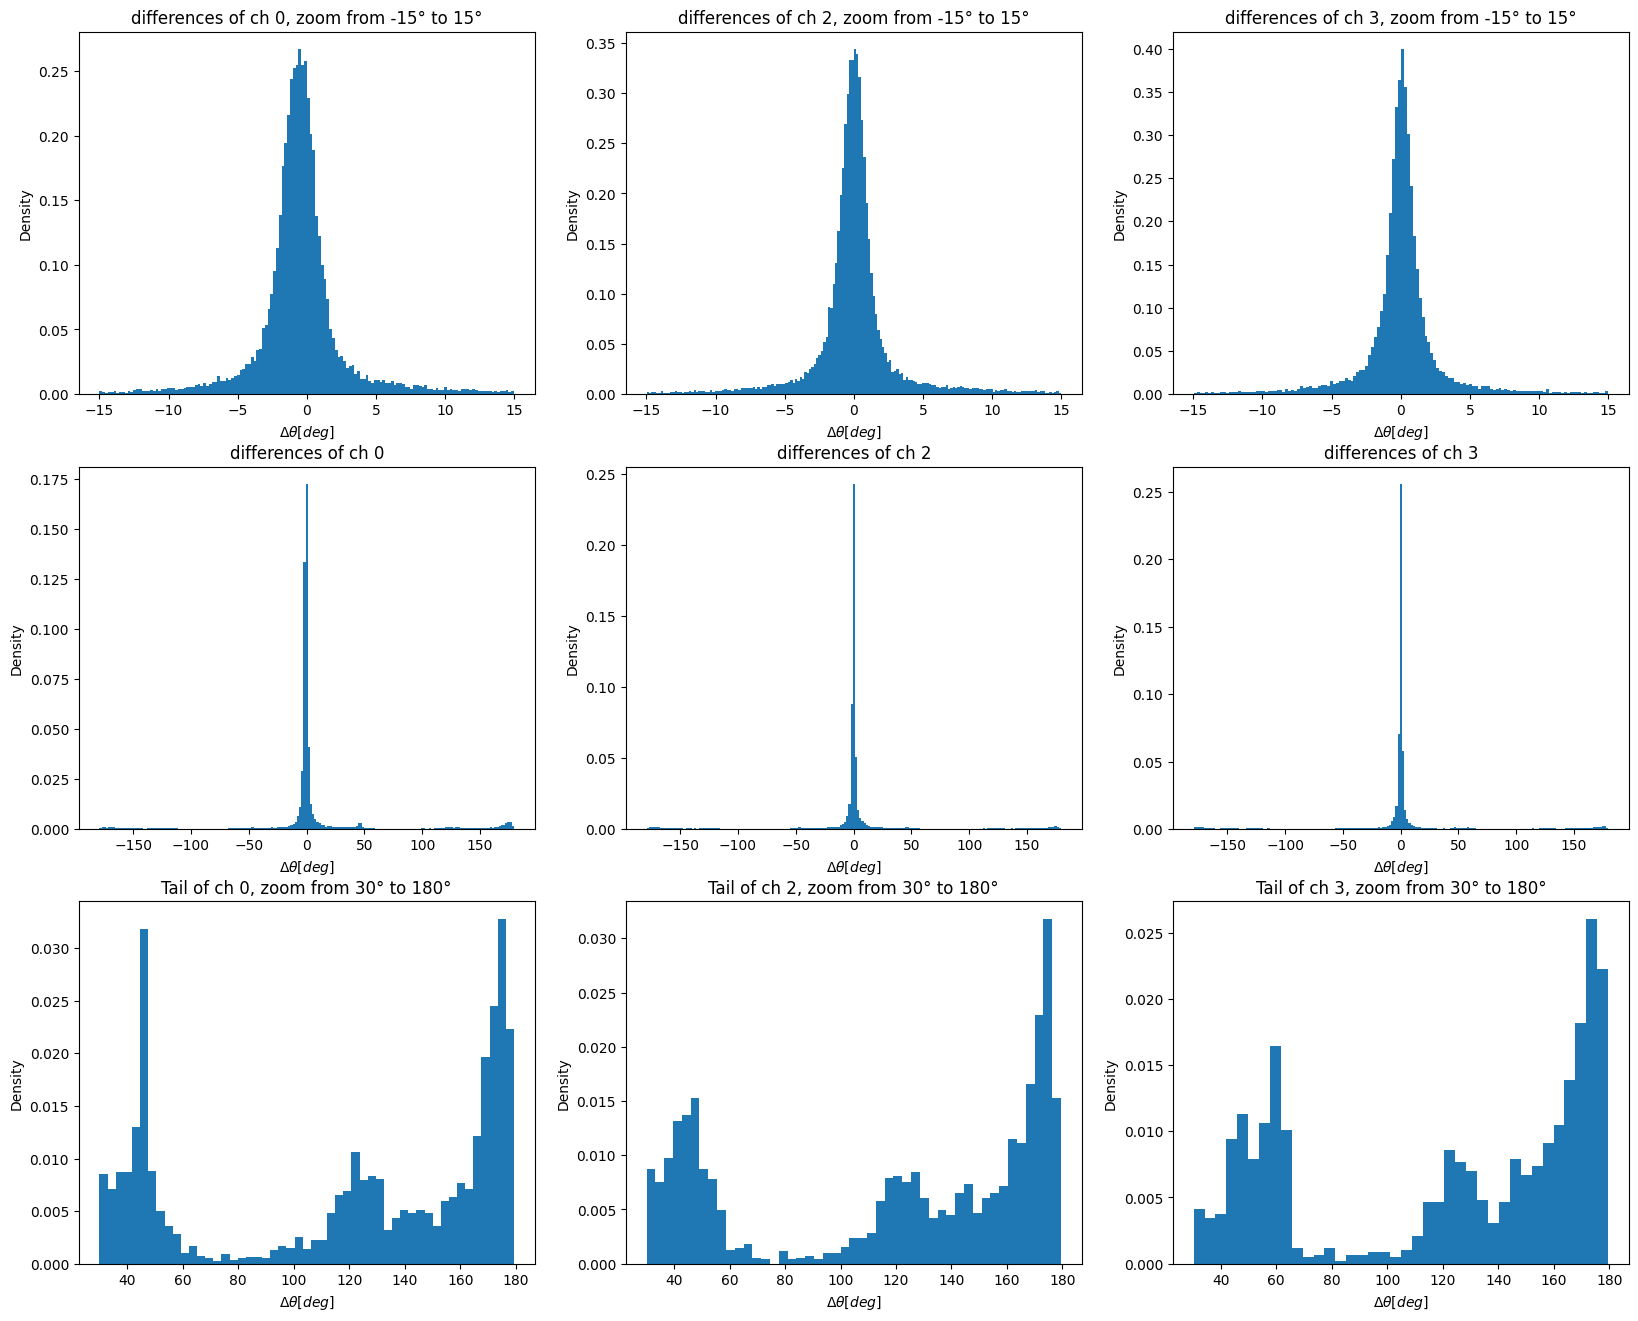

In [29]:
MAX_ANGLE = 15
plt.figure(figsize=(20, 16))
for i, ch in enumerate([0, 2, 3]):
    plt.subplot(3, 3, i + 1 + 3)
    nbins = int(np.sqrt(len(out[f'CHAMBER{ch}'])))
    plt.hist(out[f'CHAMBER{ch}'], bins=nbins, density=True)
    plt.title(f"differences of ch {ch}")
    plt.xlabel("$\Delta \\theta[deg]$")
    plt.ylabel("Density")

    values = np.array(out[[f'CHAMBER{ch}']])
    values = values[(values > - MAX_ANGLE) & (values < MAX_ANGLE)]

    plt.subplot(3, 3, i + 1)
    nbins = int(np.sqrt(len(values))) or 1
    plt.hist(values, bins=nbins, density=True)
    plt.title(f"differences of ch {ch}, zoom from -{MAX_ANGLE}° to {MAX_ANGLE}°")
    plt.xlabel("$\Delta\\theta[deg]$")
    plt.ylabel("Density")

    # zoom on tails
    low_tail, high_tail = [30, 180]
    zooms = np.array(out[[f'CHAMBER{ch}']])
    zooms = zooms[(zooms > low_tail) & (zooms < high_tail)]
    plt.subplot(3, 3, i + 1 + 6)
    nbins = int(np.sqrt(len(zooms))) or 1
    plt.hist(zooms, bins=nbins, density=True)
    plt.title(f"Tail of ch {ch}, zoom from {low_tail}° to {high_tail}°")
    plt.xlabel("$\Delta\\theta[deg]$")
    plt.ylabel("Density")

plt.show()

<p align = 'center'>
    <img src='https://raw.githubusercontent.com/RiccardoTancredi/mapdB-cosmic-rays/main/imgs/finale_immagine.png'/>
</p>

# Comparison between different **partitions** and **threads**
* Number of partitions 

<center>

| # Partitions | Time (min) |
|:------------:|:----------:|
|      9       |     26     |
|     27       |     19     |
|     81       |     17     |
|     150      |    14.3    |
|     300      |     15     |
|     600      |    14.9    |
|     900      |    15.3    |
|    1500      |    15.9    |

</center>

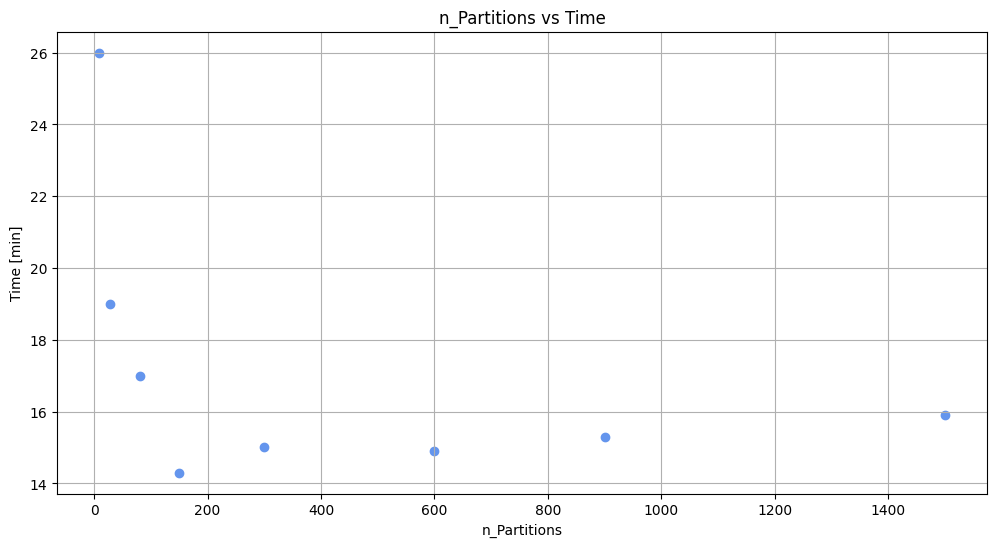

In [30]:
data = np.loadtxt("partitions.txt")
partitions = data[:, 0]
mins = data[:, 1]
plt.figure(figsize=(12, 6))
plt.scatter(partitions, mins, c="cornflowerblue")
plt.grid()
plt.xlabel("n_Partitions")
plt.ylabel("Time [min]")
plt.title("n_Partitions vs Time")
plt.show()

* Number of threads -- 150 partitions 
<center>

| # Threads per worker | Time (min) |
|:--------------------:|:----------:|
|          4           |    14.3    |
|          8           |    14.8    |
|         12           |    15.0    |

</center>

### Stop client

In [31]:
client.close()